In [ ]:
import os
import re
import sys
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import tensorflow as tf
from collections import defaultdict
from scipy.special import softmax
from scipy.stats import entropy
from scipy.signal import spectrogram
import gc

In [90]:
# -------------------- Load GPU Delegate --------------------
delegate = None
try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    from tensorflow import lite as tflite

try:
    delegate = tf.lite.experimental.load_delegate("libtensorflowlite_gpu_delegate.so")
    print("GPU delegate loaded successfully.")
except Exception as e:
    print("GPU delegate not available:", e)

# -------------------- Patch Interpreter BEFORE importing wrapper --------------------
if not hasattr(tflite, "_original_interpreter"):
    tflite._original_interpreter = tflite.Interpreter

    def Interpreter_with_delegate(*args, **kwargs):
        if delegate is not None:
            kwargs["experimental_delegates"] = [delegate]
        return tflite._original_interpreter(*args, **kwargs)

    tflite.Interpreter = Interpreter_with_delegate

Exception ignored in: <function Delegate.__del__ at 0x30db8a820>
Traceback (most recent call last):
  File "/Users/rachit/Documents/Python shit/.venv/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py", line 121, in __del__
    if self._library is not None:
AttributeError: 'Delegate' object has no attribute '_library'


GPU delegate not available: dlopen(libtensorflowlite_gpu_delegate.so, 0x0006): tried: 'libtensorflowlite_gpu_delegate.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtensorflowlite_gpu_delegate.so' (no such file), '/usr/lib/libtensorflowlite_gpu_delegate.so' (no such file, not in dyld cache), 'libtensorflowlite_gpu_delegate.so' (no such file)


In [91]:
DATASET_PATH = "/Users/rachit/Documents/Python shit/SPOT2/recordings"
STATIC_NOISE_PATH = "/Users/rachit/Documents/Python shit/StaticNoise/Untitled video - Made with Clipchamp.wav"
TARGET_SR = 48000

In [92]:
def extract_year_month_date_hour_and_minute(filename):
    """Extracts hour and minute from filenames like '2MM07103_20250330_143000.wav'."""
    match_date = re.search(r'_(\d{8})_', filename)
    match = re.search(r'_(\d{6})\.wav$', filename)
    if match and match_date:
        time_str = match.group(1)
        date_str = match_date.group(1)
        year = date_str[:4]
        month = date_str[4:6]
        date = date_str[6:]
        hour = int(time_str[:2])
        minute = int(time_str[2:4])
        return month, date, hour, minute
    return None, None, None, None

def remove_static_noise(audio, noise_ref, sr=TARGET_SR, snr_db=18):
    """
    Combines time-domain noise subtraction and spectral gating to remove static noise.
    
    1. Time-Domain Subtraction:  
       - The noise reference is padded (using 'wrap' mode) to match the audio length.
       - Its power is scaled (using the desired SNR) and subtracted from the audio.
       
    2. Spectral Gating:  
       - The resulting audio is transformed into the frequency domain using STFT.
       - A noise threshold is computed from the noise reference (via its STFT).
       - Frequency bins with energy below the threshold are zeroed out.
       - The audio is reconstructed using the inverse STFT.
    """
    # --- Time-Domain Subtraction ---
    if len(noise_ref) > len(audio):
        noise_ref = noise_ref[:len(audio)]
    else:
        noise_ref = np.pad(noise_ref, (0, len(audio) - len(noise_ref)), 'wrap')
    
    audio_power = np.mean(audio ** 2)
    noise_power = np.mean(noise_ref ** 2)
    desired_noise_power = audio_power / (10 ** (snr_db / 10))
    noise_ref_scaled = noise_ref * np.sqrt(desired_noise_power / noise_power)
    audio_td = audio - noise_ref_scaled

    # --- Spectral Gating ---
    stft = librosa.stft(audio_td, n_fft=2048, hop_length=512)
    magnitude, phase = np.abs(stft), np.angle(stft)

    noise_stft = librosa.stft(noise_ref, n_fft=2048, hop_length=512)
    noise_mag = np.abs(noise_stft)
    noise_threshold = np.mean(noise_mag, axis=1, keepdims=True) * 1.2  # threshold factor

    gated_mag = np.where(magnitude > noise_threshold, magnitude, 0)
    cleaned_stft = gated_mag * np.exp(1j * phase)
    audio_cleaned = librosa.istft(cleaned_stft, hop_length=512)

    return audio_cleaned

def compute_acoustic_indices(y, sr):
    """
    Computes four acoustic indices from the audio segment.
      - ADI (Acoustic Diversity Index): Based on Shannon entropy over frequency bins.
      - ACI (Acoustic Complexity Index): Based on the absolute changes in the spectrogram over time.
      - AEI (Acoustic Evenness Index): 1 - (normalized entropy), derived from a Gini coefficient.
      - NDSI (Normalized Difference Soundscape Index): (Bio - Anthro energy) / (Bio + Anthro energy)
    """
    f, t, Sxx = spectrogram(y, fs=sr, nperseg=1024, noverlap=512)
    Sxx = Sxx + 1e-8  # avoid log(0)
    
    # Normalize spectrogram over frequency bins (for entropy calculation)
    S_norm = Sxx / np.sum(Sxx, axis=0, keepdims=True)
    ADI = np.mean(entropy(S_norm, axis=0))
    AEI = 1.0 - (ADI / np.log(Sxx.shape[0]))
    
    # ACI: average relative change in magnitude oveSr time for each frequency bin.
    delta = np.abs(np.diff(Sxx, axis=1))
    ACI_vals = np.sum(delta, axis=1) / (np.sum(Sxx[:, :-1], axis=1) + 1e-8)
    ACI_total = np.mean(ACI_vals)
    
    # NDSI: ratio between energy in bird (bio) and anthropogenic (anthro) frequency bands.
    bio = np.logical_and(f >= 2000, f <= 11000)
    anthro = np.logical_and(f >= 100, f <= 2000)
    B = np.sum(Sxx[bio])
    A = np.sum(Sxx[anthro])
    NDSI = (B - A) / (B + A + 1e-8)
    
    return ADI, ACI_total, AEI, NDSI

In [93]:
#main execution
results=[]
noise_clip, _ = librosa.load(STATIC_NOISE_PATH, sr=TARGET_SR)
for filename in sorted(os.listdir(DATASET_PATH)):
    if filename.lower().endswith(".wav"):
        month, date, hour, minute = extract_hour_and_minute(filename)
        filepath = os.path.join(DATASET_PATH, filename)
        print(f"Processing {filename} (Hour: {hour}, Minute: {minute}) ...")
        audio, sr = librosa.load(filepath, sr=TARGET_SR)
        audio_denoised = remove_static_noise(audio, noise_clip)
        ADI, ACI, AEI, NDSI = compute_acoustic_indices(audio_denoised.flatten(), sr)
        results.append({
            "Filename": filename,
            "Year": year,
            "Month": month,
            "Date": date,
            "Hour": hour,
            "Minute": minute,
            "ADI": ADI,
            "ACI": ACI,
            "AEI": AEI,
            "NDSI": NDSI
        })

Processing 71301STOP2_20250523_200000.wav (Hour: 20, Minute: 0) ...
Processing 71301STOP2_20250523_210000.wav (Hour: 21, Minute: 0) ...
Processing 71301STOP2_20250523_220000.wav (Hour: 22, Minute: 0) ...
Processing 71301STOP2_20250523_230000.wav (Hour: 23, Minute: 0) ...
Processing 71301STOP2_20250524_000000.wav (Hour: 0, Minute: 0) ...
Processing 71301STOP2_20250524_010000.wav (Hour: 1, Minute: 0) ...
Processing 71301STOP2_20250524_020000.wav (Hour: 2, Minute: 0) ...
Processing 71301STOP2_20250524_030000.wav (Hour: 3, Minute: 0) ...
Processing 71301STOP2_20250524_040000.wav (Hour: 4, Minute: 0) ...
Processing 71301STOP2_20250524_050000.wav (Hour: 5, Minute: 0) ...
Processing 71301STOP2_20250524_060000.wav (Hour: 6, Minute: 0) ...
Processing 71301STOP2_20250524_070000.wav (Hour: 7, Minute: 0) ...
Processing 71301STOP2_20250524_080000.wav (Hour: 8, Minute: 0) ...
Processing 71301STOP2_20250524_090000.wav (Hour: 9, Minute: 0) ...
Processing 71301STOP2_20250524_100000.wav (Hour: 10, Minut

<Figure size 1200x600 with 0 Axes>

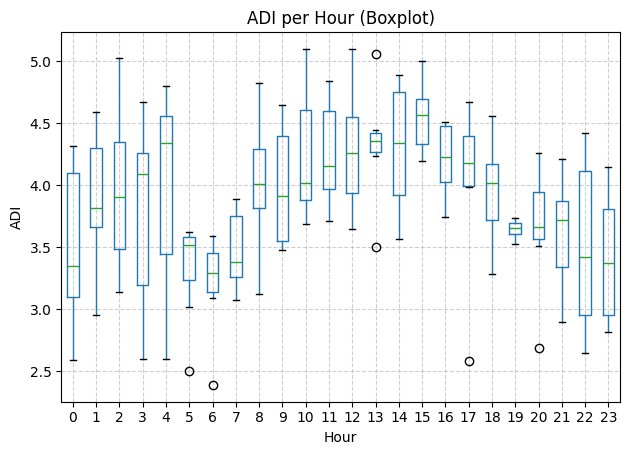

<Figure size 1200x600 with 0 Axes>

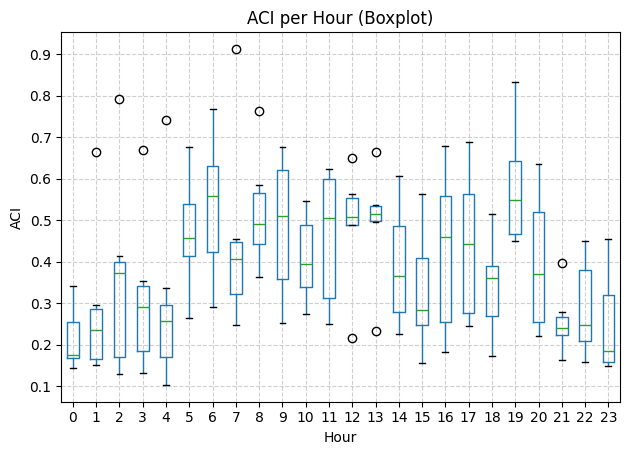

<Figure size 1200x600 with 0 Axes>

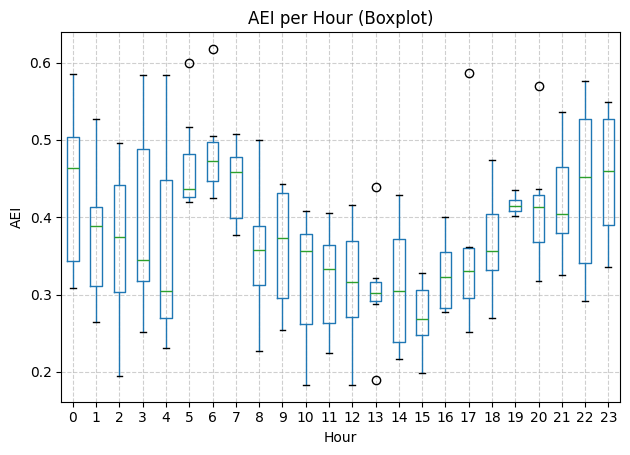

<Figure size 1200x600 with 0 Axes>

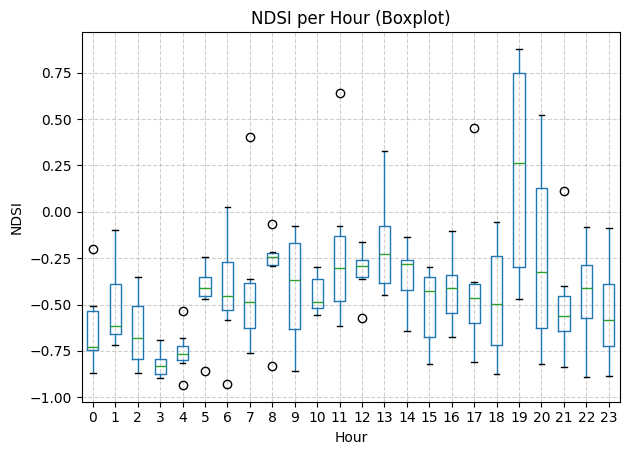

In [94]:
results_df = pd.DataFrame(results)
for idx in ["ADI", "ACI", "AEI", "NDSI"]:
    plt.figure(figsize=(12, 6))
    results_df.boxplot(column=idx, by="Hour", grid=True)
    plt.title(f"{idx} per Hour (Boxplot)")
    plt.suptitle("")
    plt.xlabel("Hour")
    plt.ylabel(idx)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"boxplot_{idx.lower()}_per_hour.png")
    plt.show()

In [ ]:
for idx in ["ADI", "ACI", "AEI", "NDSI"]:
    
    plt.figure(figsize=(12, 6))
    results_df.boxplot(column=idx, by="Hour", grid=True)
    plt.title(f"{idx} per Hour (Boxplot)")
    plt.suptitle("")
    plt.xlabel("Hour")
    plt.ylabel(idx)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"boxplot_{idx.lower()}_per_hour.png")
    plt.show()

In [116]:
#If we have multiple entries in an hour and we want a day by day comparison
# results_df.loc[results_df["date"]=="24"]
# for i in results_df["date"].unique():
#     for idx in ["ADI", "ACI", "AEI", "NDSI"]:
#         plt.figure(figsize=(12, 6))
#         results_df.loc[results_df["date"]==i].boxplot(column=idx, by="Hour", grid=True)
#         plt.title(f"{idx} per Hour (Boxplot)")
#         plt.suptitle("")
#         plt.xlabel("Hour")
#         plt.ylabel(idx)
#         plt.grid(True, linestyle="--", alpha=0.6)
#         plt.tight_layout()
#         plt.savefig(f"boxplot_{idx.lower()}_per_hour.png")
#         plt.show()


In [98]:
results_df.to_csv("/Users/rachit/Documents/Python shit/SPOT2/Indices.csv", index=False)